# Autores
- Javier Abella
- Victor Teixidó

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from sklearn import set_config
import warnings
set_config(display='text')
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 3)

# BARCELONA HOUSING

Este conjunto de datos describe características de diferentes viviendas de la ciudad de Barcelona y sus respectivos precios en función de los distintos atributos. Los datos han sido seleccionados aleatoriamente de 10 distritos distintos. La variable objetivo de nuestro conjunto de datos será *prices*, predeciremos el valor de una vivienda en función de sus características.

Los datos han sido extraídos de [kaggle](https://www.kaggle.com/datasets/jorgeglez/barcelona-idealista-housingprices).

In [ ]:
url = 'https://github.com/nemfey/fib-apa/blob/main/project/barcelona_idealista.csv?raw=true'
housing_data = pd.read_csv(url, index_col=0)

In [ ]:
housing_data.head()

,city,district,neighborhood,condition,type,rooms,area_m2,lift,views,floor,prices
0,Barcelona,Eixample,la Dreta de l'Eixample,good condition,Flat,3,351,Yes,exterior,floor 1,2300000
1,Barcelona,Sarrià-Sant Gervasi,Sant Gervasi - Galvany,good condition,Flat,5,298,Yes,exterior,floor 3,1750000
2,Barcelona,Eixample,Sant Antoni,good condition,Penthouse,2,90,Yes,exterior,floor 7,590000
3,Barcelona,Eixample,la Dreta de l'Eixample,good condition,Flat,2,130,Yes,exterior,floor 1,450000
4,Barcelona,Horta-Guinardó,Can Baró,good condition,Terraced,3,110,No,exterior,Multiple,430000


## Estadística descriptiva

El primer paso es ver la estadística descriptiva de nuestro conjunto de datos para poder obtener una idea general de como se comportan cada uno de los atributos.

In [ ]:
housing_data.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
city,3265,1,Barcelona,3265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
district,3265,10,Eixample,788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood,3265,65,la Dreta de l'Eixample,241,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,3265,3,good condition,1355,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,3265,8,Flat,2751,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rooms,3265.0,NaN,NaN,NaN,3.161,1.325,1.0,2.0,3.0,4.0,13.0
area_m2,3265.0,NaN,NaN,NaN,121.567,92.722,20.0,72.0,93.0,135.0,900.0
lift,3265,2,Yes,2727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
views,3265,2,exterior,3098,NaN,NaN,NaN,NaN,NaN,NaN,NaN
floor,3265,20,floor 1,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualización de los datos

Vamos a visualizar el comportamiento de los datos tanto individualmente como relacionados con la variable objetivo, para ver la existencia de ciertos patrones o comportamientos. También podremos ver si hay outliers o valores perdidos en el conjunto de datos.

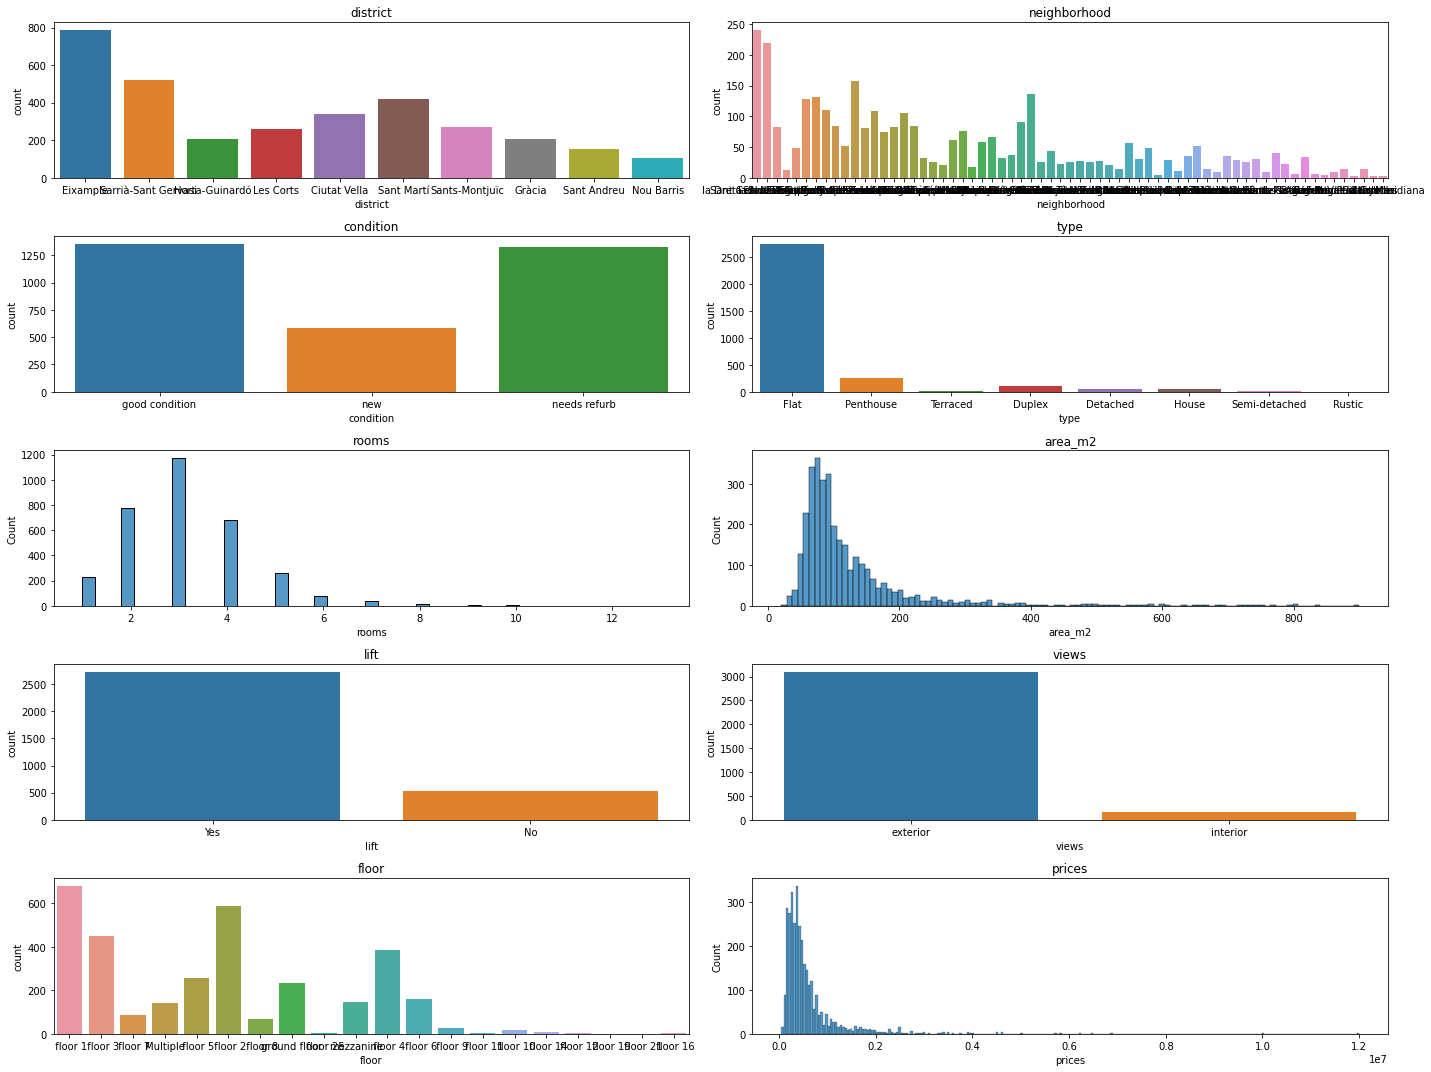

In [ ]:
fig, axes = plt.subplots(5,2,figsize=(20,15))

# city variable has no meaning (all instances in barcelona)
for i, c in enumerate(housing_data.columns[1:]):
  ax = axes.reshape(-1)[i]
  if housing_data[c].dtype.kind == 'O':
    a = sns.countplot(x=c, data=housing_data, ax=ax);
  else:
    b = sns.histplot(x=c, data=housing_data, ax=ax);
  t = ax.set_title(c);

plt.tight_layout();

### Variables númericas

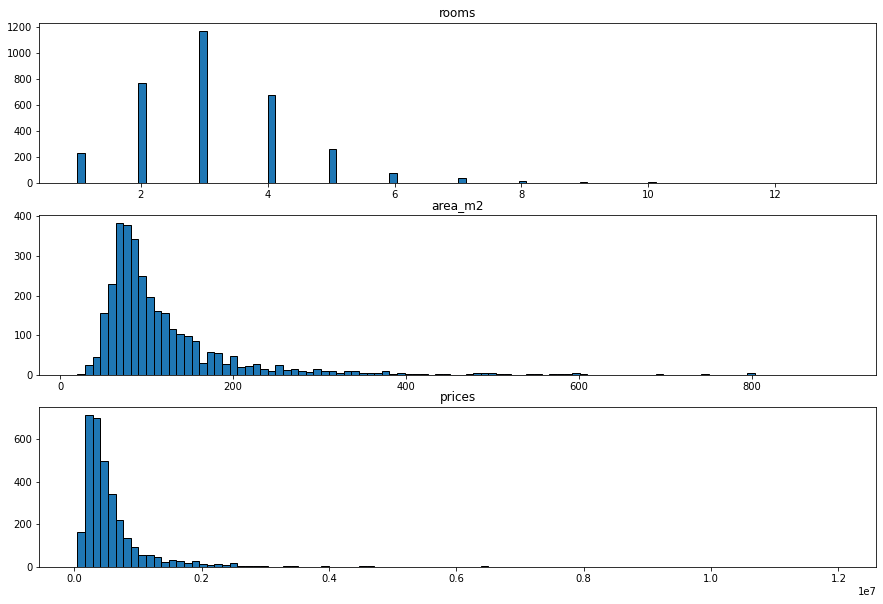

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(15,10));

ax[0].hist(housing_data['rooms'], bins=100, edgecolor='black');
ax[0].set_title('rooms');

ax[1].hist(housing_data['area_m2'], bins=100, edgecolor='black');
ax[1].set_title('area_m2');

ax[2].hist(housing_data['prices'], bins=100, edgecolor='black');
ax[2].set_title('prices');

Podemos ver como el comportamiento de la variable *rooms* es totalmente categórico, esto tiene cierto sentido ya que el número de habitaciones es una variable discreta y el rango es pequeño. Respecto a las otras dos variables, ambas parece seguir una distribución similar y cuentan con diversos valores que destacan notablemente sobre los demás.

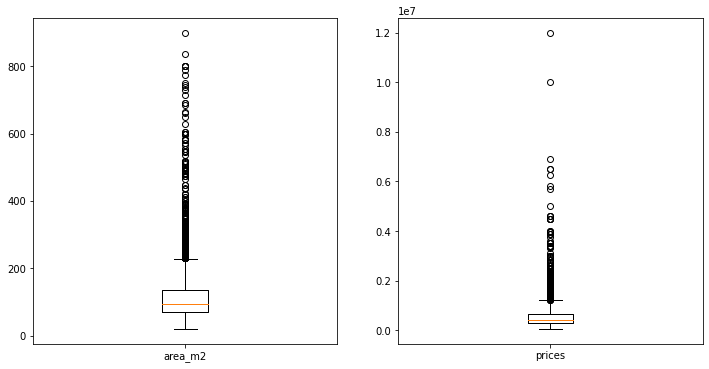

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].boxplot(housing_data['area_m2'], labels=['area_m2']);
ax[1].boxplot(housing_data['prices'], labels=['prices']);

Tal y como comentábamos antes, podemos ver como en las variables *area_m2* y *prices* existen distintos outliers. Para estos outliers no haremos ningún tipo de tratamiento, la variable *prices* es la variable objetivo y la variable *area_m2* puede contener información importante que vale la pena no modificar.

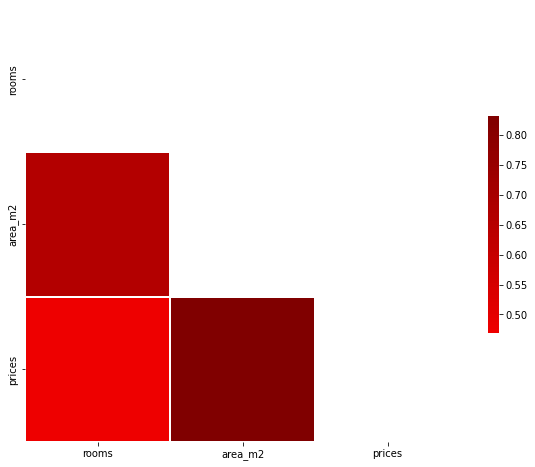

In [ ]:
corr = housing_data[['rooms','area_m2','prices']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Podemos destacar que el atributo que define los metros cuadrados de una casa tiene una alta correlación con el precio de la misma. El número de habitaciones, por otro lado, también esta positivamente correlacionado pero no tanto.

### Variables categóricas

#### City

Barcelona    3265
Name: city, dtype: int64


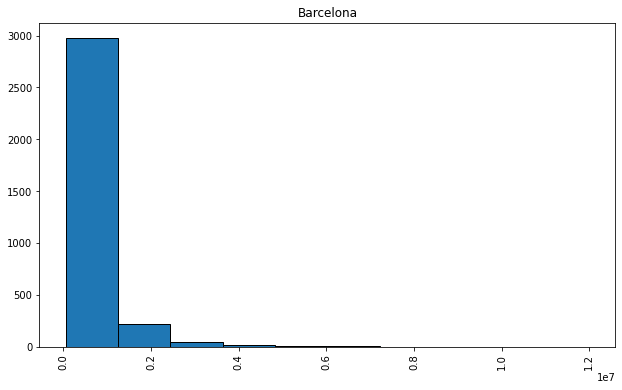

In [ ]:
print(housing_data['city'].value_counts())

housing_data.hist(column='prices', by='city', sharey=True, figsize=(10,6), edgecolor='black');

Eliminaremos esta variable del conjunto de datos ya que unicamente existe la clase *Barcelona*.

#### District

Eixample               788
Sarrià-Sant Gervasi    519
Sant Martí             420
Ciutat Vella           340
Sants-Montjuïc         271
Les Corts              257
Horta-Guinardó         206
Gràcia                 205
Sant Andreu            155
Nou Barris             104
Name: district, dtype: int64


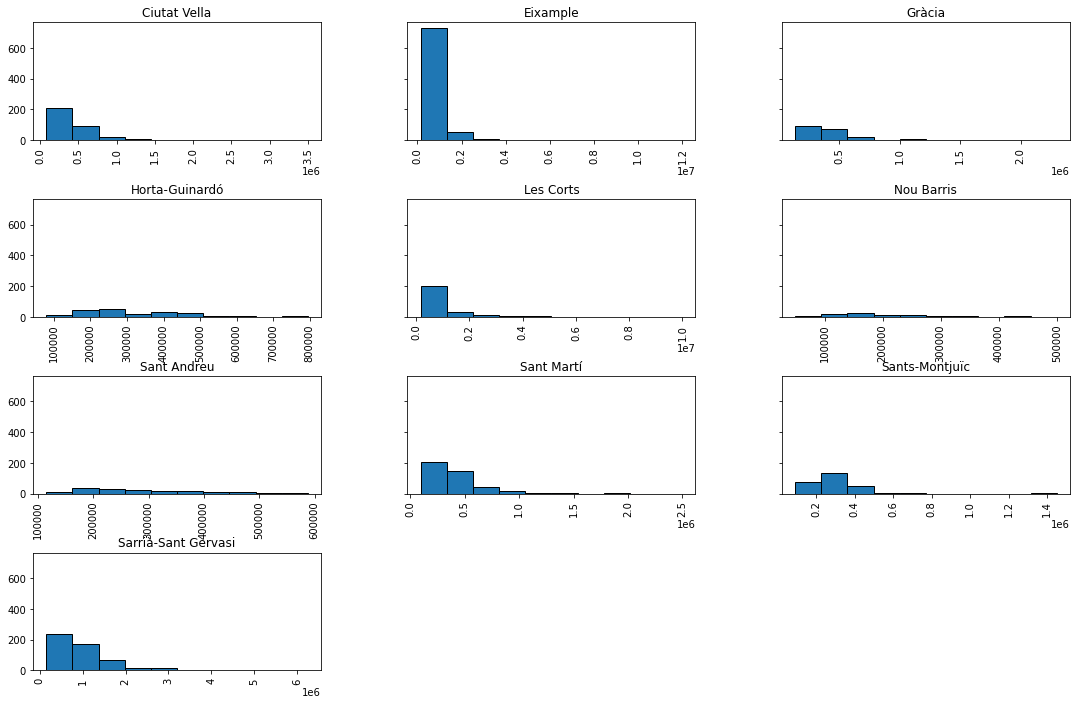

In [ ]:
print(housing_data['district'].value_counts())

housing_data.hist(column='prices', by='district', sharey=True, figsize=(18,12), edgecolor='black');

Podemos ver como la distribución de las viviendas a lo largo de los distintos barrios de barcelona es bastante equitativa. Aún asó, es lógico pensar que en barrios más grandes como puede ser el *Eixample*, hay un mayor número de viviendas en venta. De cara al preprocessing, convertiremos estas clase a númericas con one-hot encoding.

#### Neighborhood

Esta variable también la eliminaremos ya que con la variable distritos nos sirve para la representación de las distintas zonas de barcelona.

la Dreta de l'Eixample             241
Sant Gervasi - Galvany             219
l'Antiga Esquerra de l'Eixample    157
el Raval                           137
la Nova Esquerra de l'Eixample     132
                                  ... 
Can Peguera                          5
les Roquetes                         4
la Vall d'Hebron                     3
Canyelles                            3
Ciutat Meridiana                     2
Name: neighborhood, Length: 65, dtype: int64


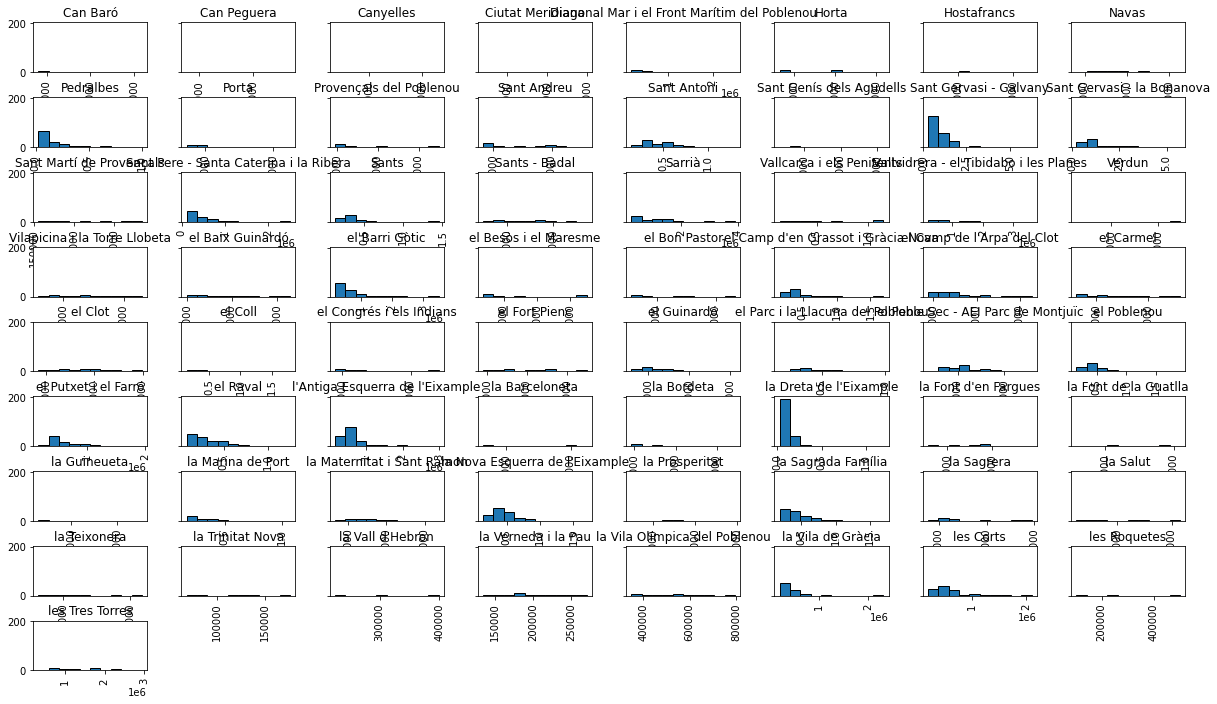

In [ ]:
print(housing_data['neighborhood'].value_counts())

housing_data.hist(column='prices', by='neighborhood', sharey=True, figsize=(20,12), edgecolor='black');

Esta variable la eliminaremos del conjunto de datos ya que es demasiado concreta y específica como para poder utilizarla a la hora de predecir valores. Al fin y al cabo, este atributo no es más que una ampliación (no necesaria en nuestro caso) de la variable *district*.

#### Condition

good condition    1355
needs refurb      1328
new                582
Name: condition, dtype: int64


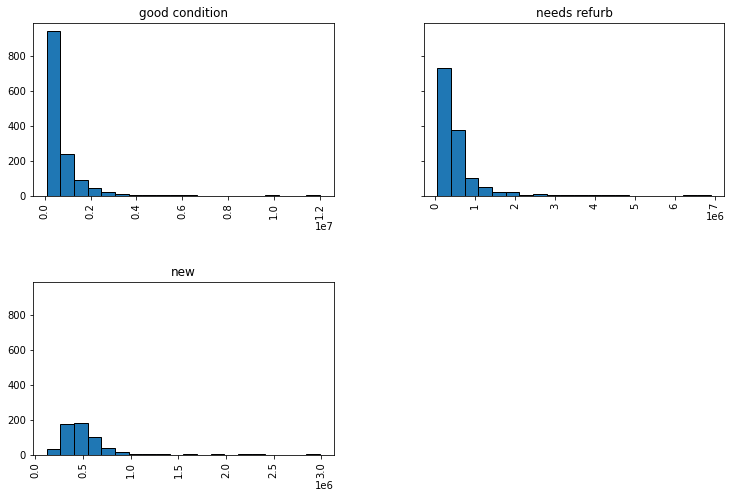

In [ ]:
print(housing_data['condition'].value_counts())

housing_data.hist(column='prices', by='condition', sharey=True, figsize=(12,8), bins=20, edgecolor='black');

La mayoría de pisos en nuestros datos son pisos en buen estado tal y como vemos en los histogramas. Podemos destacar que los pisos que, por ejemplo, superan el millón de euros son los pisos nuevos. Modificaremos esta variable asignando valores 0, 1 y 2 a la clases needs refurb, good condition y new, respectivamente. Existe una relación de orden entre las diversas categorias.

#### Type

Flat             2751
Penthouse         262
Duplex            108
Detached           55
House              54
Terraced           22
Semi-detached      12
Rustic              1
Name: type, dtype: int64


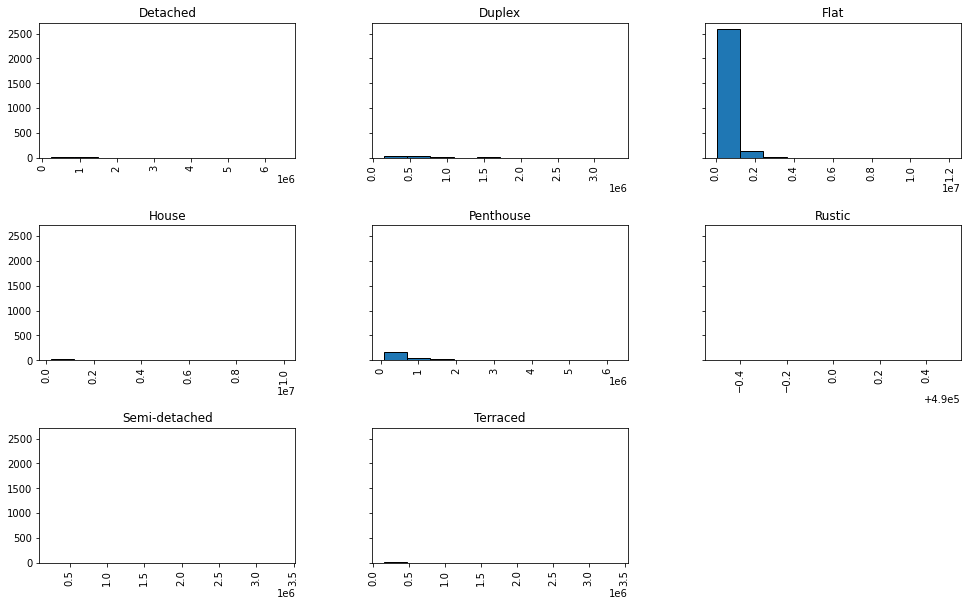

In [ ]:
print(housing_data['type'].value_counts())

housing_data.hist(column='prices', by='type', sharey=True, figsize=(16,10), edgecolor='black');

Destacar que debido a la naturalidad de la ciudad de Barcelona, predominan en abundancia las viviendas que son pisos. Debido al poco impacto en la suma total de los datos, de cara al preproccesing eliminaremos las instancias de viviendas que sean terraced, semi-detached o rustic. El resto de las clases las recodificaremos a través de one-hot encoding para poder utilizarlas en los distintos modelos.


#### Rooms

3     1174
2      773
4      679
5      261
1      232
6       81
7       36
8       14
9        6
10       6
11       2
13       1
Name: rooms, dtype: int64


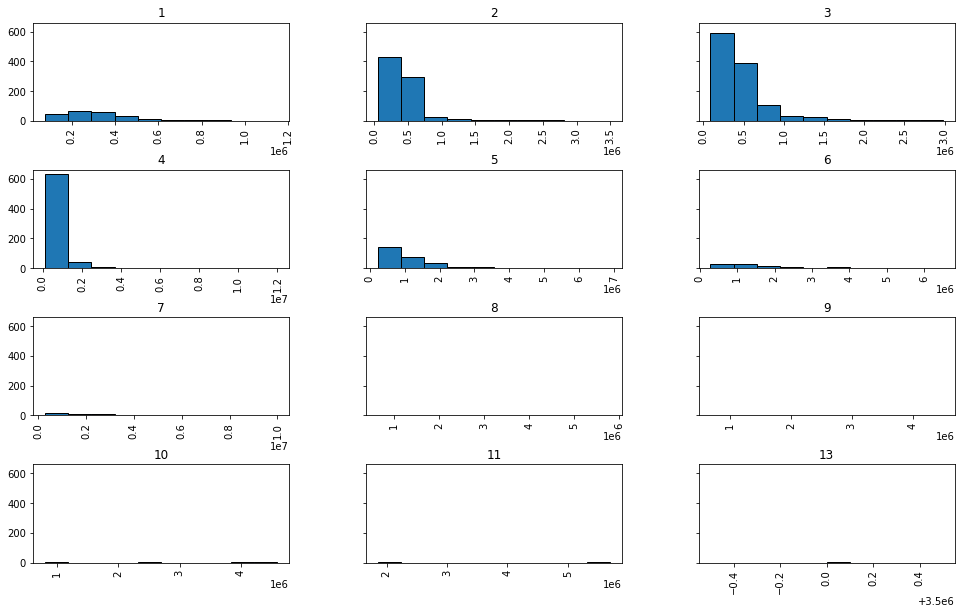

In [ ]:
print(housing_data['rooms'].value_counts())

housing_data.hist(column='prices', by='rooms', sharey=True, figsize=(16,10), edgecolor='black');

De cara al uso de este atributo en los distintos modelos, convertirmos en númericas las distintas clases. Además, reagruparemos las instancias de viviendas con un número de habitaciones mayor o igual a 6 en una misma categoría.

#### Lift

Yes    2727
No      538
Name: lift, dtype: int64


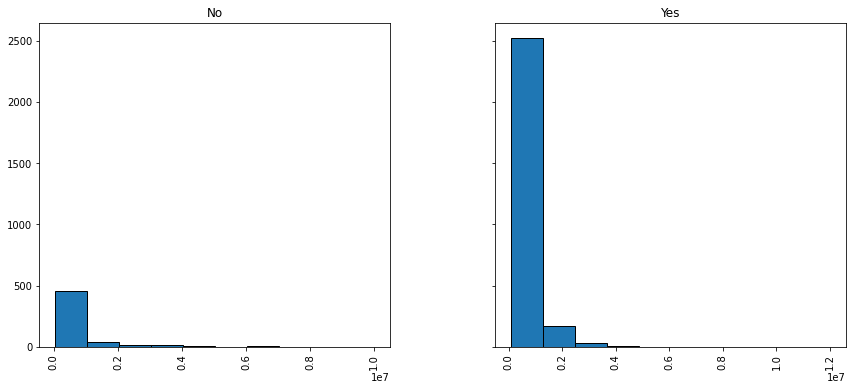

In [ ]:
print(housing_data['lift'].value_counts())

housing_data.hist(column='prices', by='lift', sharey=True, figsize=(14,6), edgecolor='black');

El número de domicilios que si disponen de ascensor es muy superior a los que no tienen. Así a priori, no parece tener un impacto muy grande al precio final de la vivienda.

#### Views

exterior    3098
interior     167
Name: views, dtype: int64


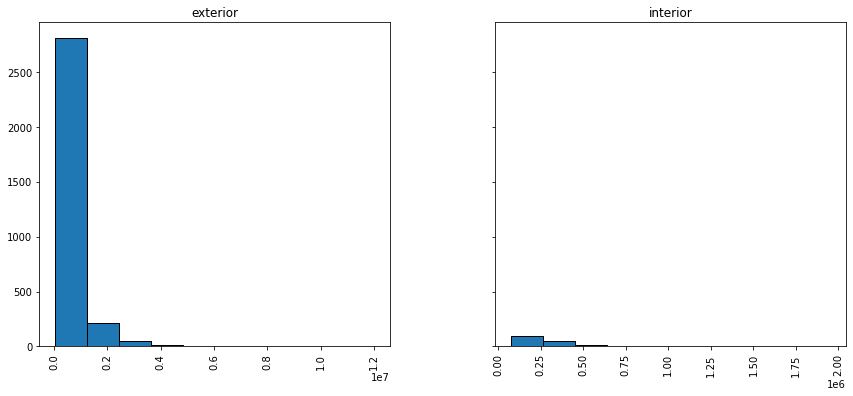

In [ ]:
print(housing_data['views'].value_counts())

housing_data.hist(column='prices', by='views', sharey=True, figsize=(14,6), edgecolor='black');

Al igual que con la variable *lift*, la gran mayoría de residencias tienen vistas al exterior. En este caso, parece que si tiene una cierta influencia en el precio final de las mismas.

#### Floor

 floor 1        681
 floor 2        588
 floor 3        452
 floor 4        385
 floor 5        259
ground floor    236
 floor 6        160
mezzanine       146
Multiple        144
 floor 7         86
 floor 8         66
 floor 9         27
 floor 10        16
 floor 14         7
 floor 11         3
 floor 12         3
 floor 25         2
 floor 16         2
 floor 19         1
 floor 21         1
Name: floor, dtype: int64


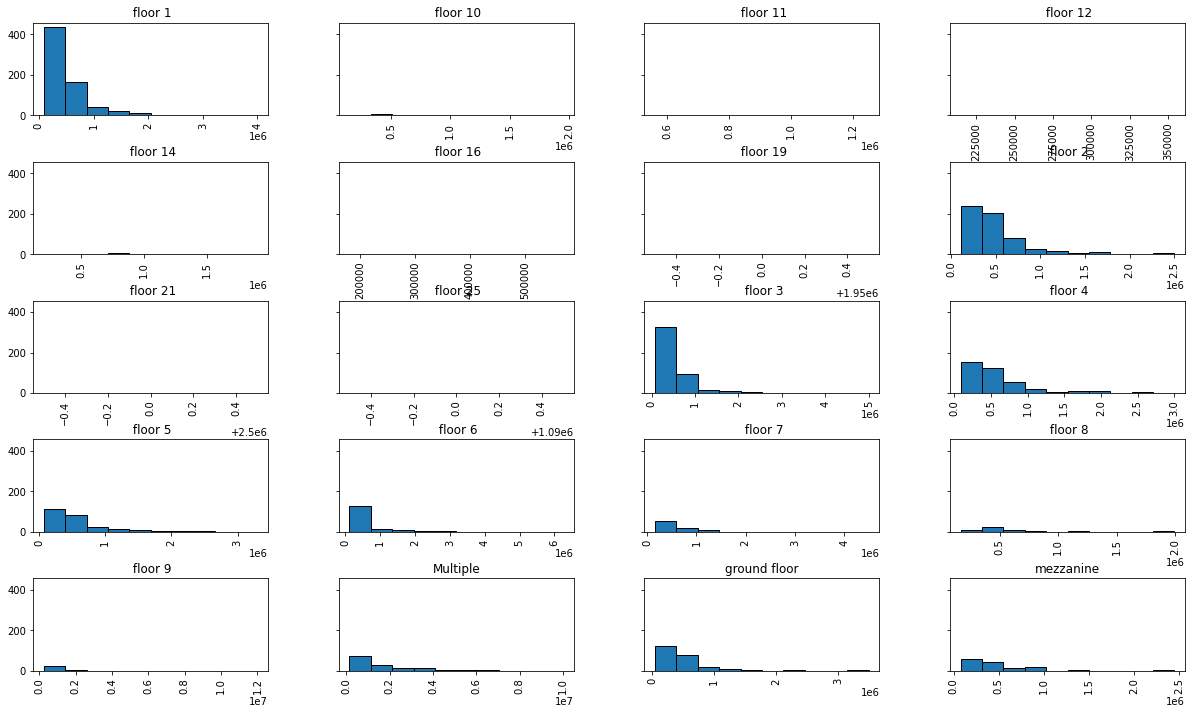

In [ ]:
print(housing_data['floor'].value_counts())

housing_data.hist(column='prices', by='floor', sharey=True, figsize=(20,12), edgecolor='black');

Fijándonos sobretodo en el número de instancias para cada uno de los pisos, hemos decidido realizar el siguiente procesamiento durante el preprocessing. Todas las variables se quedarán igual, excepto los números de plantas mayores a 6, los cuáles agruparemos en una misma categoria. Además, recodificaremos las categorias como númericas manteninedo la relación de las clases.

## División de los datos

Dividimos los datos en conjuntos de entrenamiento y test (70%/30%).

In [ ]:
from sklearn.model_selection import train_test_split

X = housing_data.loc[:,housing_data.columns != 'prices']
y = housing_data['prices']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

## Preprocessing

Vamos a modificar la variable *rooms* juntando en una sola categoría todas las viviendas con más de 5 habitaciones. Eliminamos las instancias que tengan *Terraced*, *Semi-detached* o *Rustic* como clases del atributo *type*. También juntamos en una misma clase todas las viviendas que tengan pisos más alto que el 6.

Vamos a recodificar las variables categóricas numéricamente o con one-hot enconding, según corresponda, para poder utilizar dichas variables en nuestro modelos. Renombraremos algunos atributos para amyor claridad de los datos y eliminaremos las variables *city* y *district*. Por último, eliminamos las variables categóricas y las instancias que tengan algun valor que sea na.

In [ ]:
def preprocessing(X, y):
    print('Tamaño original:{}'.format(X.shape))

    # transform some instances from rooms variable
    X.loc[(X.rooms >=6), 'rooms'] = 6
    
    # delete some instances from type variable
    index_type = X[ (X['type']=='Terraced') | (X['type']=='Semi-detached') | (X['type']=='Rustic') ].index
    X.drop(index_type, inplace=True)

    # transform some instances from floor variable
    X.loc[(X.floor!='ground floor') & (X.floor!='mezzanine') &(X.floor!='Multiple') &
                 (X.floor!=' floor 1') & (X.floor!=' floor 2') & (X.floor!=' floor 3') &
                 (X.floor!=' floor 4') & (X.floor!=' floor 5') & (X.floor!=' floor 6'), 'floor'] = 'floor>=7'
    
    # codifying categorical values to be used by our regression model 
    X['condition'].replace(['needs refurb','good condition','new'], [0,1,2], inplace=True)
    X['lift'].replace(['Yes','No'], [1,0], inplace=True)
    X['views'].replace(['exterior','interior'], [1,0], inplace=True)
    X['floor'].replace(['ground floor','mezzanine',' floor 1',' floor 2',' floor 3',' floor 4',' floor 5',' floor 6','floor>=7','Multiple'],
                       [0,1,2,3,4,5,6,7,8,9], inplace=True)
    
    # one-hot encoding district and type variables
    district_dummies = pd.get_dummies(X['district'], prefix='district', drop_first=True)
    type_dummies = pd.get_dummies(X['type'], prefix='type', drop_first=True)
    X = pd.concat([X, district_dummies, type_dummies], axis=1)
    
    # rename some attributes
    X.rename({'area_m2': 'm2', 'lift': 'has_lift', 'views': 'exterior_views'}, axis=1, inplace=True)
    
    # remove city district neighborhood and type columns
    X.drop(columns=['city','district','neighborhood','type'], inplace=True)
    
    # remove categorical variables
    categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
    X.drop(columns=categorical_columns, inplace=True)
    print('Eliminadas: {}'.format(categorical_columns))
    
    # remove missing values
    X=X.dropna()
    y=y[X.index]
    
    print('Nuevo tamaño:{}'.format(X.shape))
    return X, y

Vamos a aplicar el preprocessing especificado tanto al conjunto de entrenamiento como al conjunto de test.

In [ ]:
X_train, y_train = preprocessing(X_train,y_train)
print()
X_test, y_test = preprocessing(X_test,y_test)

Tamaño original:(2285, 10)
Eliminadas: []
Nuevo tamaño:(2265, 19)

Tamaño original:(980, 10)
Eliminadas: []
Nuevo tamaño:(965, 19)


In [ ]:
X_train.head()

,condition,rooms,m2,has_lift,exterior_views,floor,district_Eixample,district_Gràcia,district_Horta-Guinardó,district_Les Corts,district_Nou Barris,district_Sant Andreu,district_Sant Martí,district_Sants-Montjuïc,district_Sarrià-Sant Gervasi,type_Duplex,type_Flat,type_House,type_Penthouse
544,1,4,70,1,1,8,0,0,0,0,1,0,0,0,0,0,1,0,0
458,1,2,73,1,1,2,0,0,0,0,0,1,0,0,0,0,1,0,0
2703,0,4,125,1,1,3,0,0,0,0,0,0,0,0,1,0,1,0,0
2725,0,3,93,0,1,2,0,0,0,0,0,0,0,0,1,0,1,0,0
1755,2,2,77,1,1,3,0,0,0,0,0,1,0,0,0,0,1,0,0


## PCA

El primer paso será estandarizar nuestros conjuntos de entrenamiento y test ya que algunos de los modelos que utlizaremos requieren de este paso previo para poder funcionar y predecir correctamente. Utilizaremos *StandardScaler* de la librería de scikit-learn.

In [ ]:
scaler = StandardScaler()

X_train_s = X_train
X_test_s = X_test

X_train_s[X_train_s.columns] = scaler.fit_transform(X_train_s[X_train_s.columns])
X_test_s[X_test_s.columns] = scaler.transform(X_test_s[X_test_s.columns])

X_train_s.describe().T

,count,mean,std,min,25%,50%,75%,max
condition,2265.0,7.451e-17,1.0,-1.058,-1.058,0.317,0.317,1.692
rooms,2265.0,6.274e-17,1.0,-1.793,-0.953,-0.113,0.726,2.406
m2,2265.0,7.529e-17,1.0,-1.082,-0.523,-0.297,0.122,7.695
has_lift,2265.0,-4.000e-17,1.0,-2.293,0.436,0.436,0.436,0.436
exterior_views,2265.0,-1.435e-16,1.0,-4.155,0.241,0.241,0.241,0.241
floor,2265.0,5.019e-17,1.0,-1.645,-0.779,-0.347,0.519,2.250
district_Eixample,2265.0,3.215e-17,1.0,-0.564,-0.564,-0.564,-0.564,1.774
district_Gràcia,2265.0,-4.392e-17,1.0,-0.259,-0.259,-0.259,-0.259,3.867
district_Horta-Guinardó,2265.0,1.882e-17,1.0,-0.264,-0.264,-0.264,-0.264,3.782
district_Les Corts,2265.0,6.274e-18,1.0,-0.296,-0.296,-0.296,-0.296,3.373


In [ ]:
pca = PCA().fit(X_train_s);

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.14529165 0.09142064 0.0780757  0.0746578  0.06266661 0.06029302
 0.05780881 0.05716183 0.05589285 0.05540334 0.05274172 0.04877863
 0.04526159 0.0393322  0.02981708 0.02402348 0.01376465 0.00534947
 0.00225891]
[0.14529165 0.2367123  0.31478799 0.3894458  0.4521124  0.51240543
 0.57021424 0.62737607 0.68326892 0.73867227 0.79141399 0.84019262
 0.8854542  0.92478641 0.95460349 0.97862696 0.99239162 0.99774109
 1.        ]


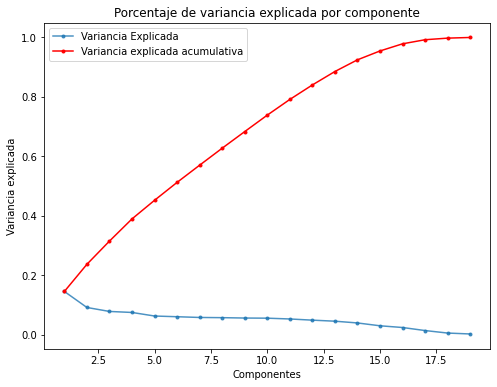

In [ ]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         pca.explained_variance_ratio_ , alpha=0.8, marker='.',
         label="Variancia Explicada");

y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');

plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red', marker='.',
         label="Variancia explicada acumulativa");
         
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

En esta gráfica podemos ver cuanto aporta una nueva componente a medida que vamos añadiendo. Para tener representado el 100% de la variancia explicada acumulada, necesitaríamos un total de 19 componentes.

Vamos a ver la correlación que existe entre las variables del conjunto de entrenamiento.

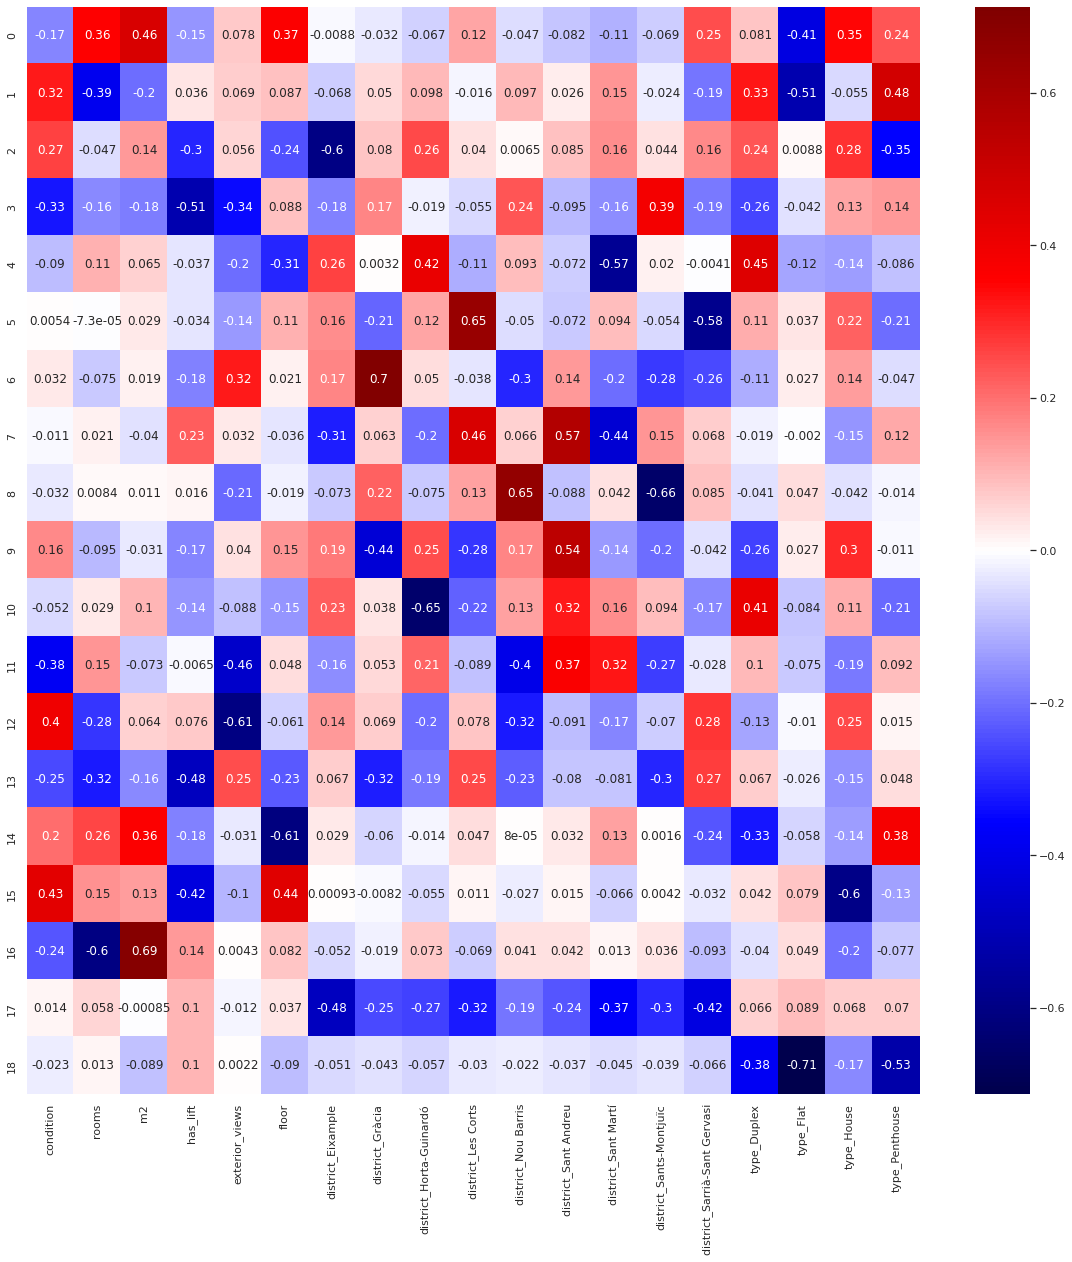

In [ ]:
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(pca.components_, cmap='seismic',
            xticklabels=X_train_s.columns,
            vmin=-np.max(np.abs(pca.components_)),
            vmax=np.max(np.abs(pca.components_)),
            annot=True);

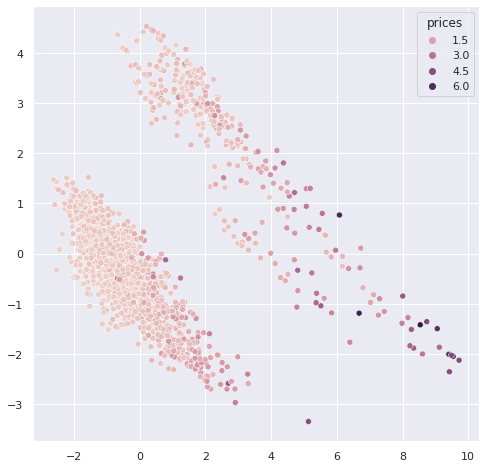

In [ ]:
X_trans = pca.transform(X_train_s)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train);

Podemos ver como la gran mayoría de casas de nuestro conjunto de datos pertenecen a los precios más bajos y que, por otro lado, hya pocos individuos que pertenezcan al grupo de viviendas realmente caras. Esto podrá llegar a ser un problema a la hora de tener buenos resultados debido a la poca información  sobre las casas caras.

## Remuestreo

Utilizaremos la función utilizada en el curso donde comprobamos los resultados utilizando los datos del conjunto de test y la validación cruzada. Durante el entrenamiento de todos los modelos utilizaremos 10 como el valor de cross validation. Compararemos resultados obtenidos entre los modelos y, dentro del mismo modelo, entre los conjuntos de test y de entrenamiento.

In [ ]:
from sklearn.model_selection import cross_val_score
cv = 10

def save_results(clf, nclf, X, y, df):
    df.loc[nclf,'test_score'] = clf.score(X, y)
    df.loc[nclf,'cross_val_score'] = clf.best_score_
    return df

results_df = pd.DataFrame()

## Modelos de regresión lineal

De entre todos los modelos de regresión lineal que hemos visto durante el curso, vamos a utilizar tres para obtener los resultados de las predicciones y compararlos entre ellos. Estos 3 son:
- Regresión LASSO
- Regresión Ridge
- Máquina de soport vectorial con un kernel polinómico

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from yellowbrick.regressor import residuals_plot, prediction_error, AlphaSelection
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### Regresión LASSO

Empezaremos por explorar los distintos hiperparámetros del modelo y observar con cuáles obetenemos los mejores resultados.


In [ ]:
param = {
        'alpha':[1e-4,0.001,0.01,0.1, 0.5,1,5,10,50,100,300,500],
        'max_iter':[1000,10000,50000],
        'selection':["cyclic", "random"]
         }

lasso = Lasso()

lasso_gs = GridSearchCV(lasso, param, cv = cv,n_jobs = -1);
lasso_gs.fit(X_train_s,y_train);

In [ ]:
show_html(pd.DataFrame(lasso_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
3,"{'alpha': 0.0001, 'max_iter': 10000, 'selection': 'random'}",0.761,1
5,"{'alpha': 0.0001, 'max_iter': 50000, 'selection': 'random'}",0.761,2
0,"{'alpha': 0.0001, 'max_iter': 1000, 'selection': 'cyclic'}",0.761,3
2,"{'alpha': 0.0001, 'max_iter': 10000, 'selection': 'cyclic'}",0.761,3
4,"{'alpha': 0.0001, 'max_iter': 50000, 'selection': 'cyclic'}",0.761,3


Tras entrenar el modelo miramos cuáles han sido los mejores 5 resultados de combinaciones de hiperparámetros. Vemos como los primeros resultados son iguales pero nos quedaremos con el primero: alpha = 0.01, max_iter = 50000 y selection = random. 

In [ ]:
results_df = save_results(lasso_gs, 'LASSO regression', X_test_s, y_test, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
LASSO regression,0.659,0.761


Guardamos los resultados para poder compararlo con los demás modelos, de estos resultados podemos decir que son buenos pero tampoco son increíbles.

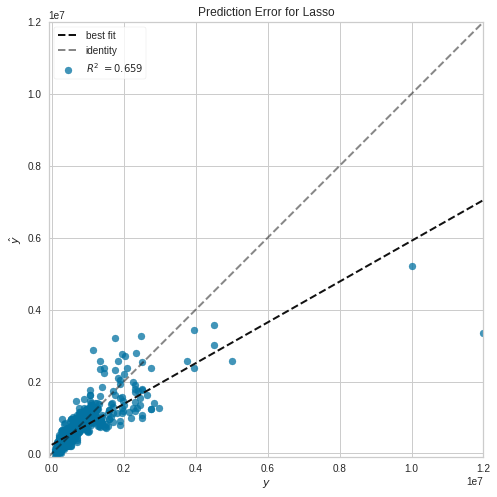

In [ ]:
plt.figure(figsize=(12,8));
visualizer = prediction_error(lasso_gs.best_estimator_, X_train_s, y_train, X_test_s, y_test)
plt.show();

En esta gráfica podemos ver la representación de las predicciones sobre el conjunto test. Observamos que la mayoria de los precios de vivienda sonbajos comparandolo con los precios de algunas viviendas que son bastante más caras.
Lo que hace que como vemos en el gráfico la mayoria de precios se acumulen al principio y el best fit se desvíe tanto.

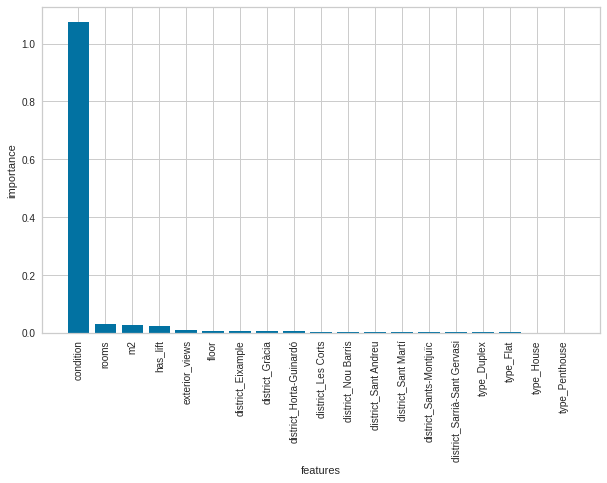

In [ ]:
result = permutation_importance(lasso_gs, X_test_s, y_test, n_repeats=10, random_state=1, n_jobs=-1)

feature_names = X_test.columns
importances = np.sort(result['importances_mean'])[::-1]

plt.figure(figsize=(10,6));
plt.bar(feature_names, importances);
plt.xlabel('features');
plt.ylabel('importance');
plt.xticks(rotation=90);
plt.show();

En este gráfico de importancia de atributos, donde el atributo con más importancia es el de “condition” siendo la importancia de este muy significativa respecto a la de los demás atributos y también podemos apreciar como los 3 siguientes atributos más significativos son el número de habitaciones, la superficie y si tiene o no ascensor.

### Ridge Regression

Vamos a seguir el proceso habitual de explorar los distintos hiperparámetros del modelo y luego ver con que valores obtenemos los mejores resultados.

In [ ]:
param_grid = {
              'alpha': [0.01,0.1, 1, 10, 100,200,500],
               'max_iter':[1000,10000,50000],
              'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
              }

ridge = Ridge()
ridge_gs = GridSearchCV(ridge, param_grid, cv=cv)
ridge_gs.fit(X_train_s, y_train);

In [ ]:
show_html(pd.DataFrame(ridge_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
76,"{'alpha': 10, 'max_iter': 1000, 'solver': 'sparse_cg'}",0.762,1
92,"{'alpha': 10, 'max_iter': 50000, 'solver': 'sparse_cg'}",0.762,1
84,"{'alpha': 10, 'max_iter': 10000, 'solver': 'sparse_cg'}",0.762,1
93,"{'alpha': 10, 'max_iter': 50000, 'solver': 'sag'}",0.762,4
94,"{'alpha': 10, 'max_iter': 50000, 'solver': 'saga'}",0.762,5


En esta tabla vemos los 5 mejores resultados de combinaciones de hiperparámetros y vemos que hay 3 que tienen exactamente la misma puntuación, escogeremos el primero que sale.

In [ ]:
results_df = save_results(ridge_gs, 'Ridge regression', X_test_s, y_test, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
LASSO regression,0.659,0.761
Ridge regression,0.657,0.762


Vemos aquí que el resutlado del test es peor que el del anterior modelo de Lasso pero ha mejorado en la puntuación de la validación cruzada.

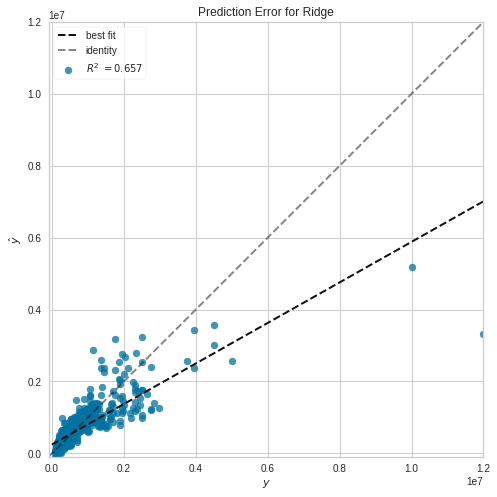

In [ ]:
plt.figure(figsize=(12,8));
visualizer = prediction_error(ridge_gs.best_estimator_, X_train_s, y_train, X_test_s, y_test)
plt.show();

En esta gráfica vemos la puntuación del modelo con el conjunto de test y vemos como hemos perdido acierto, debido probablemente al sobreajuste del modelo al conjunto de entrenamiento.

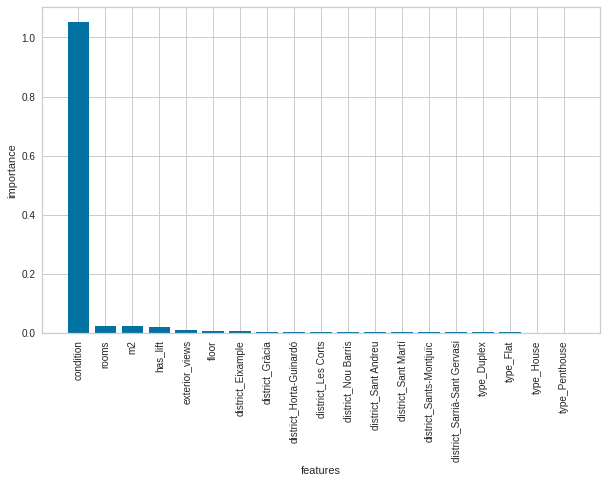

In [ ]:
result = permutation_importance(ridge_gs, X_test_s, y_test, n_repeats=10, random_state=1, n_jobs=-1)

feature_names = X_test.columns
importances = np.sort(result['importances_mean'])[::-1]

plt.figure(figsize=(10,6));
plt.bar(feature_names, importances);
plt.xlabel('features');
plt.ylabel('importance');
plt.xticks(rotation=90);
plt.show();

Como ya vimos en el anterior modelo el atributo que más importancia tiene es la condición del piso seguido por el número de habitaciones la superficie y si tiene o no ascensor, luego ya casi sin relevancia están tanto el piso como los distintos distritos.

### Polynomial SVM

Vamos a seguir el proceso habitual de explorar los distintos hiperparámetros del modelo y luego ver con que valores obtenemos los mejores resultados.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

params = {'C': 10**np.linspace(-3,3,20),
          'gamma': 10**np.linspace(-9,3,20),
          'degree':[2,3]}

svm =  SVR(kernel='poly', max_iter=25000, cache_size=2000)
svm_gs =  GridSearchCV(svm, params, cv=cv, n_jobs=-1)
svm_gs.fit(X_train_s, y_train);

In [ ]:
show_html(pd.DataFrame(svm_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
236,"{'C': 0.0379269019073225, 'degree': 3, 'gamma': 12.742749857031322}",0.740,1
475,"{'C': 2.976351441631316, 'degree': 3, 'gamma': 2.976351441631313}",0.740,2
714,"{'C': 233.57214690901213, 'degree': 3, 'gamma': 0.6951927961775591}",0.740,3
276,"{'C': 0.07847599703514611, 'degree': 3, 'gamma': 12.742749857031322}",0.738,4
754,"{'C': 483.2930238571752, 'degree': 3, 'gamma': 0.6951927961775591}",0.738,5


Podemos ver como los resultados obtenidos durante el *fit* del conjunto de entrenamiento son buenos pero sin más, y es notable que apenas hay diferencia entre los primeros 5 resultados, el mejor de estos tiene un acierto de 0.740. Este lo hemos obtenido con una *C* igual a 0.0379 aproximadamente, con un *degree* igual a 3 y con un valor de *gamma* igual a, aproximadamente, 12.7427.

In [ ]:
results_df = save_results(svm_gs, 'Polynomial SVM', X_test_s, y_test, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
LASSO regression,0.659,0.761
Ridge regression,0.657,0.762
Polynomial SVM,0.610,0.740


Podemos ver como el nuevo modelo entrenado, basado en una SVM con kernel polinómico, es relativamente peor que el que habíamos visto en los apartados anteriores. Tanto en en la calidad del modelo con los datos del test como con la puntuación de la validación cruzada. Podemos ver como, al igual que ocurría antes, la predicción sobre el conjunto test es bastante inferior a la obtenido durante el cross validation.

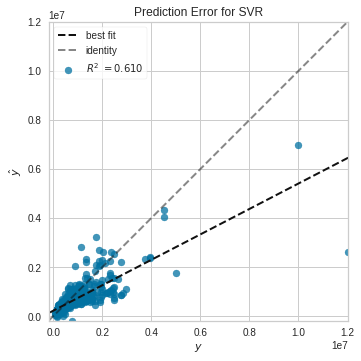

In [ ]:
from yellowbrick.regressor import prediction_error

visualizer = prediction_error(svm_gs.best_estimator_, X_train_s, y_train, X_test, y_test)

En este gráfico podemos ver la representación de las predicciones sobre el conjunto test. Podemos ver, tal y como decíamos antes, que la mayoría de precios de viviendas son relativamente bajos, comparados a algunas viviendas que son mucho más caras. Esto, tal y como se puede apreciar, hace que los precios se acumulen al principio, y que el *best fit* acabe notoriamente desviado.

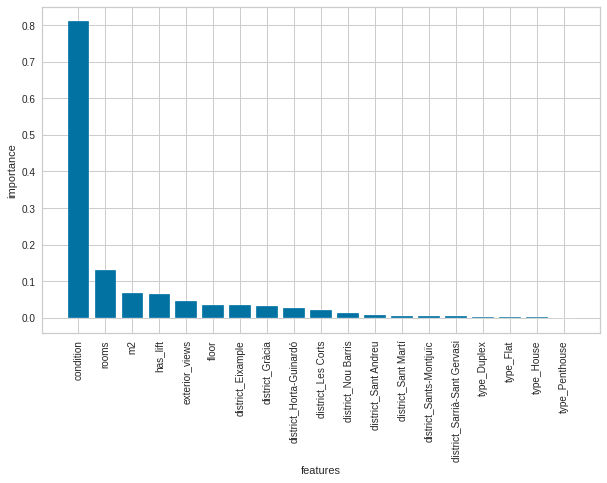

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(svm_gs, X_test_s, y_test, n_repeats=10, random_state=1, n_jobs=-1)

feature_names = X_test.columns
importances = np.sort(result['importances_mean'])[::-1]

plt.figure(figsize=(10,6));
plt.bar(feature_names, importances);
plt.xlabel('features');
plt.ylabel('importance');
plt.xticks(rotation=90);
plt.show();

La importancia que le da este modelo a los distintos atributos de nuestros datos es prácticamente idéntico al que veíamos con los anteriores modelos. Parece ser que el parámetro que definen una salida es la condición del piso en venta, este atributo acapara la mayoría de la importancia. Por otro lado, vemos como el peso de las variables *rooms* y *m2*, ha aumentado ligeramente respecto a los otros modelos vistos.

## Modelos de regresión no lineal

De entre todos los modelos de regresión no lineal que hemos visto durante el curso, vamos a utilizar tres para obtener los resultados de las predicciones y compararlos entre ellos. Estos 3 son:
- Random forest
- Gradient boosting
- Stacked regressor con los dos mejores modelos

### Random Forest

Vamos a seguir el proceso habitual de explorar los distintos hiperparámetros del modelo y luego ver con qu valores obtenemos los mejores resultados.

In [ ]:
param = {'n_estimators': [5, 10, 25, 40, 50, 75, 100, 200], 
         'criterion':['mse'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1, 2, 3, 5, 10]}

rf =  RandomForestRegressor(random_state=1)
rf_gs =  GridSearchCV(rf,param, cv=cv, n_jobs=-1)
rf_gs.fit(X_train, y_train);

In [ ]:
show_html(pd.DataFrame(rf_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
285,"{'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 75}",0.799,1
286,"{'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}",0.799,2
5,"{'criterion': 'mse', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 75}",0.799,3
6,"{'criterion': 'mse', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}",0.798,4
287,"{'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}",0.798,5


Aquí vemos las mejores combinaciones de hiperparámetros siendo la mejor la de usar criterion = mse, 'max__depth' = 10, 'min_samples_leaf' = 1, 'n_estimators' = 75

In [ ]:
results_df = save_results(rf_gs, 'Random forest', X_test, y_test, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
LASSO regression,0.659,0.761
Ridge regression,0.657,0.762
Random forest,0.622,0.799
Polynomial SVM,0.610,0.740


Si comparamos los resultados obtenidos con este modelo podemos observar que son los peores obtenidos hasta el momento estando 0.012 por debajo del anterior modelo y 0.021 por debajo de la siguiente peor puntuación de validación cruzada.

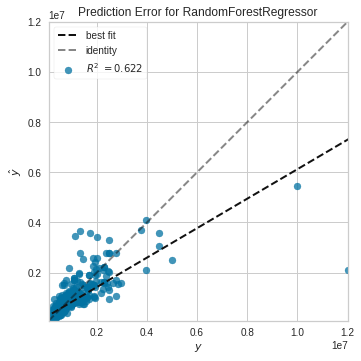

In [ ]:
visualizer = prediction_error(rf_gs.best_estimator_, X_train, y_train, X_test, y_test)

En cuanto a la puntuación de aplicar el modelo a los datos del test vemos que los datos también son bastante malos y vemos además como en los anteriores modelos que la mayoría de ejemplos están agrupados al principio ya que el precio de las viviendas suele ser "bajo" aunque haya ejemplos que se desvían bastante de la mayoría.

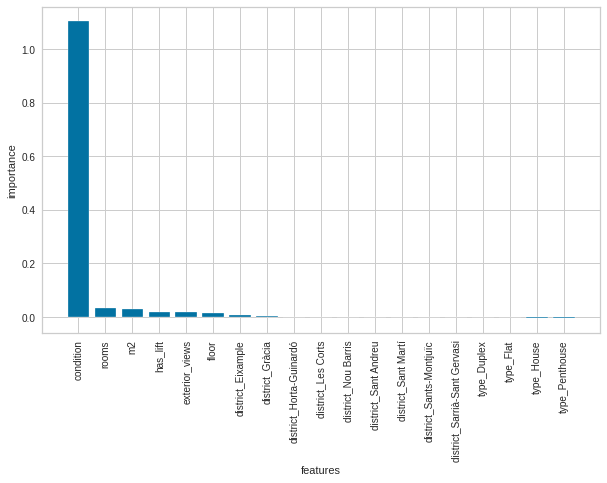

In [ ]:
result = permutation_importance(rf_gs, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)

feature_names = X_test.columns
importances = np.sort(result['importances_mean'])[::-1]

plt.figure(figsize=(10,6));
plt.bar(feature_names, importances);
plt.xlabel('features');
plt.ylabel('importance');
plt.xticks(rotation=90);
plt.show();

En cuanto a la importancia de atributos vemos que la variable 'condition' sigue siendo la más importante por una diferencia más que notaria seguido por el número de habitaciones 'rooms' la superfície 'm2' si tiene o no ascensor 'has_lift' o si tiene vistas al exterior o al interior 'exterior_views'. 

### Gradient boosting

Vamos a seguir el proceso habitual de explorar los distintos hiperparámetros del modelo y luego ver con que valores obtenemos los mejores resultados.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

params={'n_estimators':[10, 100, 250, 500, 1000],
        'learning_rate':[.001, 0.01, .1, 1],
        'max_depth':[1, 2, 5, 10],
        'subsample':[.5,.75,1],
        'loss':['squared_error', 'absolute_error']}

gbr = GradientBoostingRegressor(random_state=1)
gbr_gs = GridSearchCV(gbr, params)
gbr_gs.fit(X_train, y_train)

In [ ]:
show_html(pd.DataFrame(gbr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
237,"{'learning_rate': 0.01, 'loss': 'absolute_error', 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.5}",0.813,1
160,"{'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.75}",0.811,2
238,"{'learning_rate': 0.01, 'loss': 'absolute_error', 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.75}",0.811,3
163,"{'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.75}",0.810,4
159,"{'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.5}",0.810,5


Podemos ver como los resultados obtenidos durante el *fit* del conjunto de entrenamiento son razonablemente buenos, y es notable que no hay mucha diferencia entre los primeros 5 resultados, el mejor de estos tiene un acierto de 0.813. Este lo hemos obtenido con un *learning_rate* de 0.01, utilizando el error absoluto como función de pérdida, con el valor de *max_depth* igual a 10, el número de estimadores igual a 1000 y *subsample* igual a 0.5.

In [ ]:
results_df = save_results(gbr_gs, 'Gradient boosting', X_test, y_test, results_df)
results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
LASSO regression,0.659,0.761
Ridge regression,0.657,0.762
Gradient boosting,0.630,0.813
Random forest,0.622,0.799
Polynomial SVM,0.610,0.740


Podemos ver como el nuevo modelo entrenado, basado en gradient boosting, es mejor que algunos de los modelos vistos pero peor que los mejores modelos obtenidos hasta ahora, pero como resultado general sigue teniendo un amplio margen de mejora. Este modelo es el que mejor *cross_val_score* ha obtenido. Podemos ver como, al igual que ocurría antes, la predicción sobre el conjunto test es bastante inferior a la obtenido durante el cross validation.

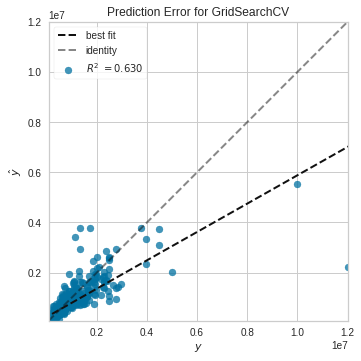

In [ ]:
from yellowbrick.regressor import prediction_error

visualizer = prediction_error(gbr_gs, X_train, y_train, X_test, y_test)

En este gráfico podemos ver la representación de las predicciones sobre el conjunto test. Podemos ver, tal y como decíamos antes, que la mayoría de precios de viviendas son relativamente bajos, comparados a algunas viviendas que son mucho más caras. Esto, tal y como se puede apreciar, hace que los precios se acumulen al principio, y que el *best fit* acabe notoriamente desviado.

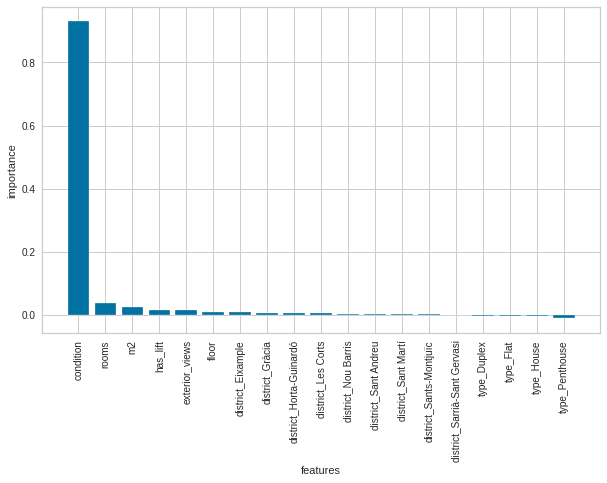

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(gbr_gs, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)

feature_names = X_test.columns
importances = np.sort(result['importances_mean'])[::-1]

plt.figure(figsize=(10,6));
plt.bar(feature_names, importances);
plt.xlabel('features');
plt.ylabel('importance');
plt.xticks(rotation=90);
plt.show();

La importancia que le da este modelo a los distintos atributos de nuestros datos es prácticamente idéntico al que veíamos con los anteriores modelos. Parece ser que el parámetro que definen una salida es la condición del piso en venta, este atributo acapara más del 80% de importancia.

### Stacked regressor

Vamos a utilizar los modelos que utilizan la regresión LASSO y la regresión Ridge, para entrenar el nuevo modelo que utiliza Stacked regressor. Estos dos modelos son los que mejores resultados han obtenido de entre todos los vistos.

In [ ]:
from sklearn.ensemble import StackingRegressor

st_r = StackingRegressor([('rf', ridge_gs.best_estimator_),
                          ('gbr', lasso_gs.best_estimator_)],
                          cv=cv, n_jobs=-1)
                             
st_r.fit(X_train, y_train);

In [ ]:
results_df.loc['Stacked regressor','test_score'] = st_r.score(X_test_s, y_test)
results_df.loc['Stacked regressor','cross_val_score'] = cross_val_score(st_r, X_train_s, y_train, cv=cv).mean()

results_df.sort_values(by='test_score', ascending=False)

,test_score,cross_val_score
LASSO regression,0.659,0.761
Ridge regression,0.657,0.762
Stacked regressor,0.655,0.762
Gradient boosting,0.630,0.813
Random forest,0.622,0.799
Polynomial SVM,0.610,0.740


Podemos ver como el nuevo modelo entrenado, basado en stacked regressor y utilizando las regresiones lasso y ridge, es mejor que algunos de los modelos vistos pero peor que los mejores modelos obtenidos hasta ahora. Como resultado general sigue teniendo un amplio margen de mejora ya que ha obtenido un acierto sobre el conjunto test de 0.655. Podemos ver como, al igual que ocurría antes, la predicción sobre el conjunto test es bastante inferior a la obtenido durante el cross validation.

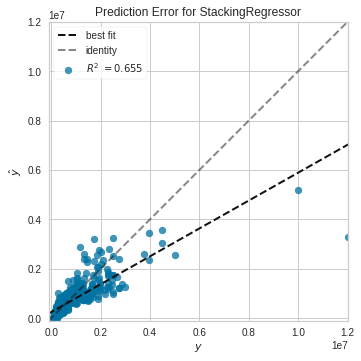

In [ ]:
str_visualizer = prediction_error(st_r, X_train, y_train, X_test, y_test);

En este gráfico podemos ver la representación de las predicciones sobre el conjunto test. Podemos ver, tal y como decíamos antes, que la mayoría de precios de viviendas son relativamente bajos, comparados a algunas viviendas que son mucho más caras. Esto, tal y como se puede apreciar, hace que los precios se acumulen al principio, y que el *best fit* acabe notoriamente desviado.

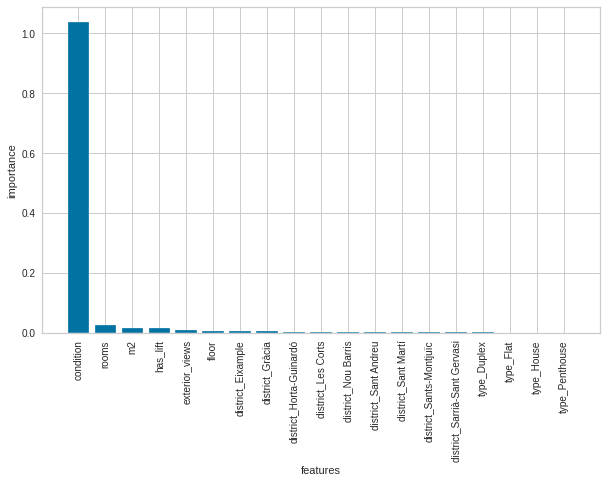

In [ ]:
result = permutation_importance(st_r, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)

feature_names = X_test.columns
importances = np.sort(result['importances_mean'])[::-1]

plt.figure(figsize=(10,6));
plt.bar(feature_names, importances);
plt.xlabel('features');
plt.ylabel('importance');
plt.xticks(rotation=90);
plt.show();

La importancia que le da este modelo a los distintos atributos de nuestros datos es prácticamente idéntico al que veíamos con los anteriores modelos. Parece ser que el parámetro que definen una salida es la condición del piso en venta, este atributo acapara prácticamente toda la importancia.